# WISDM HAR

Class
- Walking, Jogging, Upstairs, Downstairs, Sitting, Standing

Sampling rate
- 20Hz

Fields
- user, activity, timestamp, x-acceleration, y-acceleration, z-acceleration



In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPool1D, BatchNormalization, Dense, Input, ReLU, Dropout, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";") # comment: ';'로 시작하는 줄 무시(주석)


In [25]:
data.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,NaN
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,NaN
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,NaN
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,NaN
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,NaN
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,NaN


In [26]:
df = data.drop('NaN', axis=1)
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,1


In [27]:
df = df.dropna()
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,0


In [28]:
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')

df["x_axis"] = df["x_axis"].astype('float32')
df["y_axis"] = df["y_axis"].astype('float32')
df["z_axis"] = df["z_axis"].astype('float32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float32
 4   y_axis     1098203 non-null  float32
 5   z_axis     1098203 non-null  float32
dtypes: float32(3), int64(2), object(1)
memory usage: 46.1+ MB


In [29]:
df['activity'].value_counts()

,count
activity,
Walking,424397
Jogging,342176
Upstairs,122869
Downstairs,100427
Sitting,59939
Standing,48395


In [30]:
df['user_id'].value_counts()

,count
user_id,
20,56632
19,45383
31,44282
8,41188
29,38245
14,38192
13,37093
34,35947
32,35506


In [31]:
# Label Encoding
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
num_classes = len(label_encoder.classes_)

df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,activity_encoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [32]:
# label_encoder 매핑 결과 보기
dict(enumerate(label_encoder.classes_))

{0: 'Downstairs',
 1: 'Jogging',
 2: 'Sitting',
 3: 'Standing',
 4: 'Upstairs',
 5: 'Walking'}

In [33]:
# Data Split
df_train = df[df['user_id'] <= 28]
df_val = df[(df['user_id'] > 28) & (df['user_id'] <= 32)]
df_test = df[df['user_id'] > 32]

In [34]:
# 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.fit_transform(df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']])
# test 셋에서 train에서 학습한 scaler 사용
df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']])
df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']])

Segmentation
- 슬라이딩 윈도우 방식
- 데이터를 time_steps만큼 자르고 step 간격으로 이동
- 해당 구간에서 가장 많이 나타난 label을 출력값으로 저장
- 결과적으로 딥러닝 모델에 넣을 수 있는 3차원 입력 데이터와 라벨 벡터를 생성
- 3차원 입력 데이터: (샘플 수, 한 샘플이 가지는 시간 길이, feature 개수)

In [35]:
def create_dataset(x, y, time_steps=200, step=40):
    xs, ys = [], []
    for i in range(0, len(x) - time_steps, step):
        v = x.iloc[i:i + time_steps].values
        labels = y.iloc[i:i + time_steps]
        values, counts = np.unique(labels, return_counts=True)
        mode_label = values[np.argmax(counts)]
        xs.append(v)
        ys.append(mode_label)
    return np.array(xs), np.array(ys)

TIME_STEPS = 100
STEP = 50
x_train, y_train = create_dataset(df_train[['x_axis', 'y_axis', 'z_axis']], df_train['activity_encoded'], TIME_STEPS, STEP)
x_val, y_val = create_dataset(df_val[['x_axis', 'y_axis', 'z_axis']], df_val['activity_encoded'], TIME_STEPS, STEP)
x_test, y_test = create_dataset(df_test[['x_axis', 'y_axis', 'z_axis']], df_test['activity_encoded'], TIME_STEPS, STEP)

In [36]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((16694, 100, 3), (16694,), (2866, 100, 3), (2866,), (2400, 100, 3), (2400,))

In [37]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(weights))
print(class_weights_dict)

{0: np.float64(1.858606101091071), 1: np.float64(0.5291619120071003), 2: np.float64(3.324173636001593), 3: np.float64(4.177677677677678), 4: np.float64(1.4870835560306432), 5: np.float64(0.4238131505458238)}


## Model 1
- LSTM 3

In [43]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    LSTM(256, return_sequences=True),
    LSTM(128, return_sequences=False),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 256)       │       266,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,646 (1.83 MB)

 Trainable params: 480,646 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

None


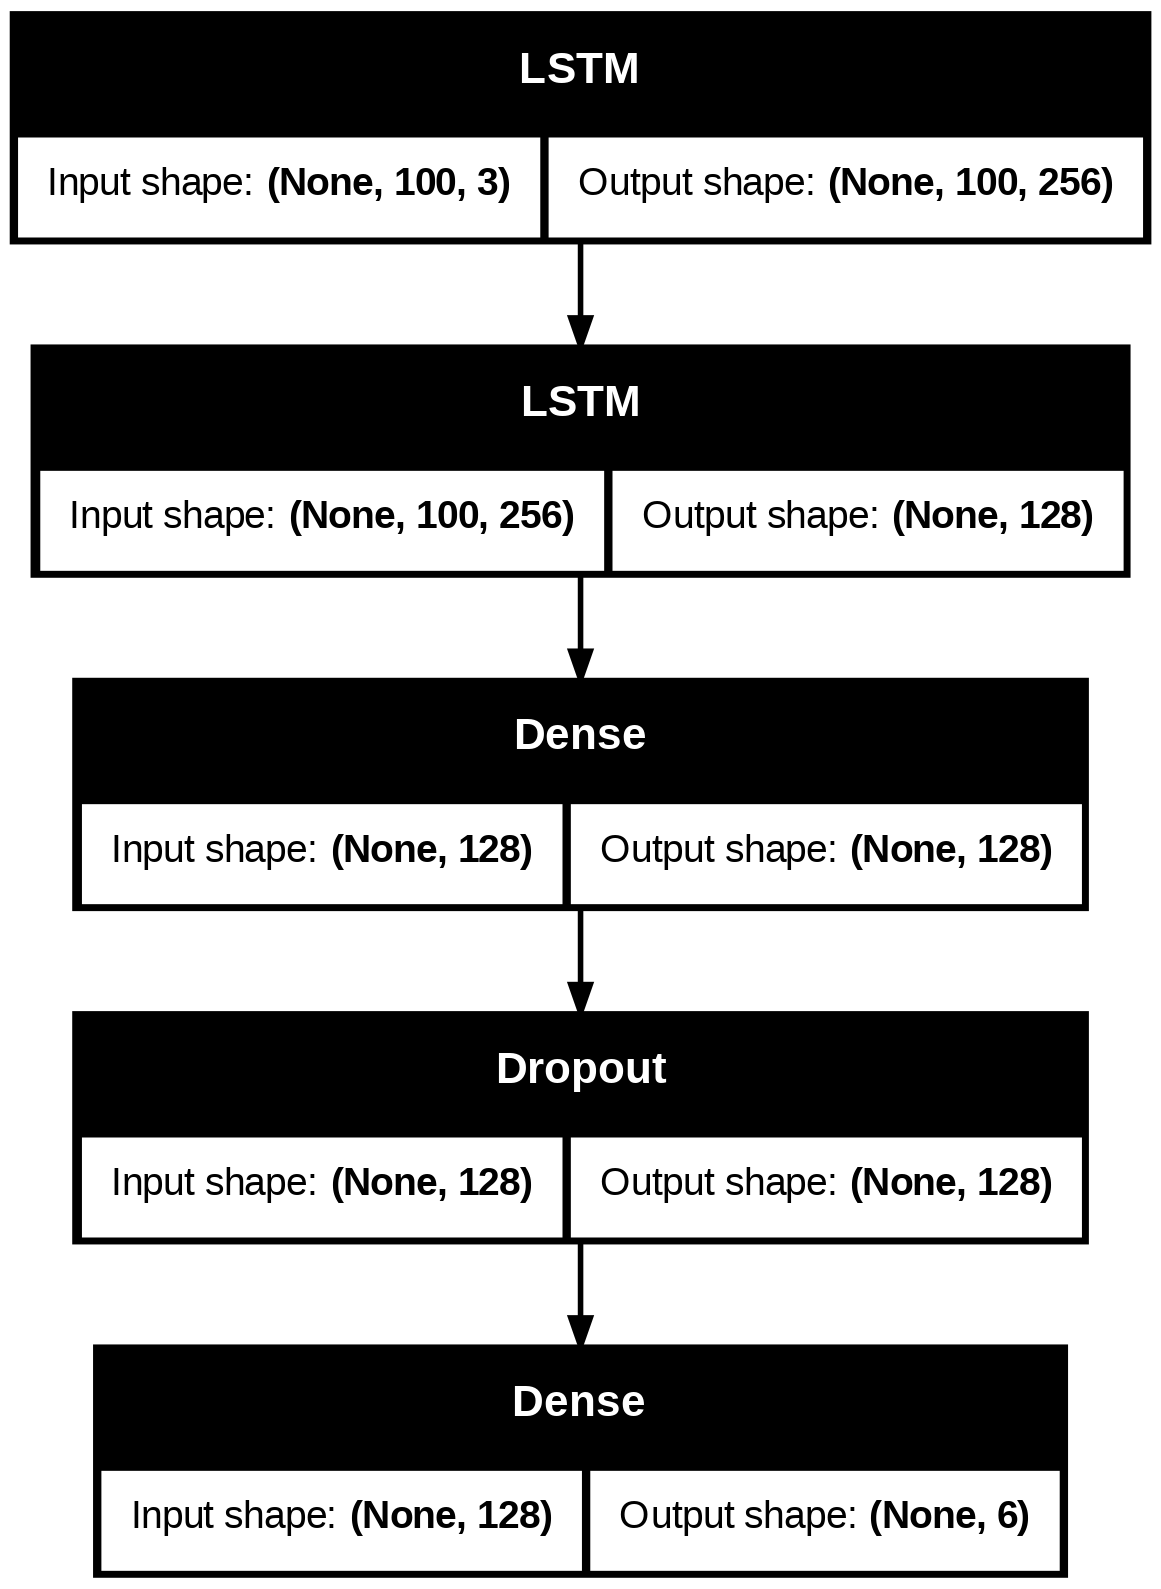

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [45]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_LSTM_best.h5",
                save_best_only=True,
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=20,
                verbose=1,
                mode='min',
                restore_best_weights=True
            )
        ]

In [46]:
history = model.fit(
            x_train, y_train,
            epochs=50,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/50
258/261 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1241 - sparse_categorical_accuracy: 0.6341
Epoch 1: val_loss improved from inf to 1.03311, saving model to WIDSM_HAR_LSTM_best.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.1212 - sparse_categorical_accuracy: 0.6350 - val_loss: 1.0331 - val_sparse_categorical_accuracy: 0.6511
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7405 - sparse_categorical_accuracy: 0.7520
Epoch 2: val_loss improved from 1.03311 to 0.95204, saving model to WIDSM_HAR_LSTM_best.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.7403 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.9520 - val_sparse_categorical_accuracy: 0.6828
Epoch 3/50
258/261 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5046 - sparse_categorical_accuracy: 0.8314
Epoch 3: val_loss improved from 0.95204 to 0.69873, saving model to WIDSM_HAR_LSTM_best.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.5040 - sparse_categorical_accuracy: 0.8315 - val_loss: 0.6987 - val_sparse_categorical_accuracy: 0.7432
Epoch 4/50
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3868 - sparse_categorical_accuracy: 0.8671
Epoch 4: val_loss improved from 0.69873 to 0.63300, saving model to WIDSM_HAR_LSTM_best.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.3866 - sparse_categorical_accuracy: 0.8672 - val_loss: 0.6330 - val_sparse_categorical_accuracy: 0.7742
Epoch 5/50
259/261 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2841 - sparse_categorical_accuracy: 0.9029
Epoch 5: val_loss did not improve from 0.63300
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.9030 - val_loss: 0.9755 - val_sparse_categorical_accuracy: 0.7694
Epoch 6/50
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2345 - sparse_categorical_accuracy: 0.9224
Epoch 6: val_loss did not improve from 0.63300
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.2344 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.6919 - val_sparse_categorical_accuracy: 0.7913
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1916 - sparse_categorical_accuracy: 0.9374
Epoch 7: val_loss did not improve from 0.63300
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.1916 - sparse_categor

261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1436 - sparse_categorical_accuracy: 0.9555 - val_loss: 0.4821 - val_sparse_categorical_accuracy: 0.8475
Epoch 9/50
259/261 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9577
Epoch 9: val_loss did not improve from 0.48206
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.9578 - val_loss: 1.3556 - val_sparse_categorical_accuracy: 0.7872
Epoch 10/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.9626
Epoch 10: val_loss did not improve from 0.48206
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9626 - val_loss: 1.3791 - val_sparse_categorical_accuracy: 0.7718
Epoch 11/50
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.9681
Epoch 11: val_loss did not improve from 0.48206
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.1060 - sparse_cat

In [47]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_LSTM_best.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 96.54%
Training loss: 0.1030
Test accuracy: 90.79%
Test loss: 0.3766


In [48]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7366    0.8465    0.7878       228
           1     0.9960    0.9295    0.9616       808
           2     0.9832    0.9888    0.9860       178
           3     1.0000    0.9667    0.9831       120
           4     0.6045    0.8034    0.6899       234
           5     0.9704    0.9075    0.9379       832

    accuracy                         0.9079      2400
   macro avg     0.8818    0.9070    0.8910      2400
weighted avg     0.9236    0.9079    0.9133      2400



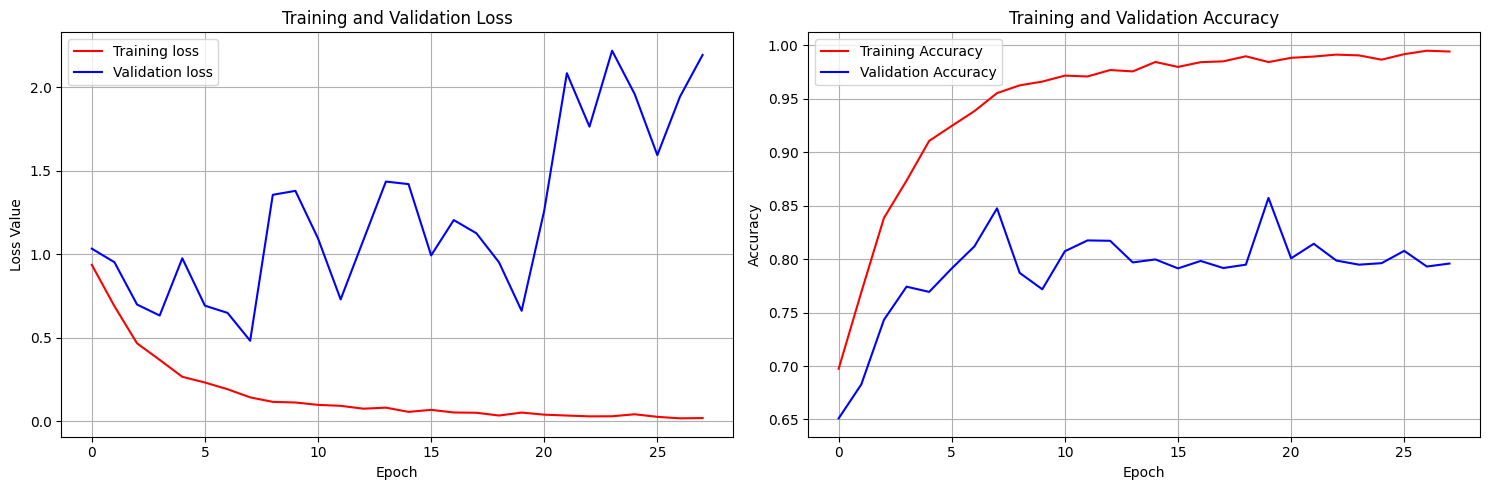

In [49]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

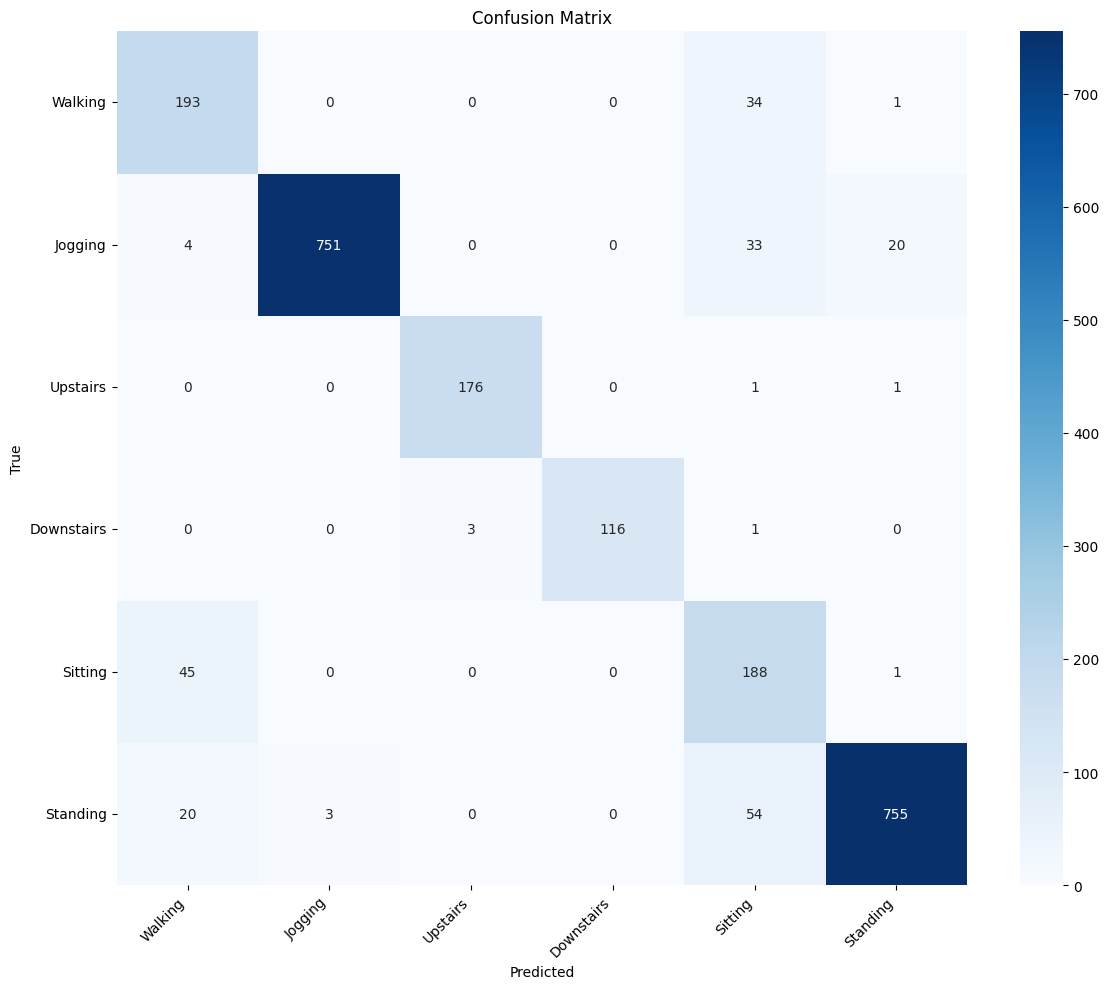

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()